In [2]:
!pip install transformers datasets scikit-learn --quiet

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import datasets
from datasets import Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load data
hidden_df = pd.read_csv("/content/drive/MyDrive/GP(AI2025)/Data/Scraped Data/Hidden Market/Detailed_Data.csv")

# Filter for specified drug categories
valid_categories = {'eBooks','Carding','Dump','Drugs Production','Theft'}
df = hidden_df[hidden_df['Category'].isin(valid_categories)].copy()
df = df.rename(columns={'Name': 'text', 'Category': 'label'})

# Create label mappings
label2id = {label: i for i, label in enumerate(sorted(df['label'].unique()))}
id2label = {i: label for label, i in label2id.items()}
df['label'] = df['label'].map(label2id)

print(f"Total samples: {len(df)}")
print("Class distribution:")
print(df['label'].value_counts().rename(index=id2label))

Total samples: 1341
Class distribution:
label
eBooks              962
Carding             192
Dump                101
Theft                43
Drugs Production     43
Name: count, dtype: int64


In [6]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,  # 80% train, 20% temp
    stratify=df['label'],
    random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,  # 10% val, 10% test
    stratify=temp_labels,
    random_state=42
)

print(f"Train samples: {len(train_texts)}")
print(f"Val samples: {len(val_texts)}")
print(f"Test samples: {len(test_texts)}")

Train samples: 1072
Val samples: 134
Test samples: 135


In [7]:
# RoBERTa Version
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True  # Critical for adapting pretrained model
)

# Special RoBERTa tokenizer settings
tokenizer.add_special_tokens({
    'additional_special_tokens': ['💊', '🔌', '🔥']  # Add dark web tokens
})
model.resize_token_embeddings(len(tokenizer))  # Update embedding layer

# Verify
print("✓ RoBERTa loaded successfully")
print("Class mappings:", id2label)
print("Tokenizer vocab size:", len(tokenizer))
print("Last layer:", model.classifier.out_proj)  # RoBERTa's classification head

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


✓ RoBERTa loaded successfully
Class mappings: {0: 'Carding', 1: 'Drugs Production', 2: 'Dump', 3: 'Theft', 4: 'eBooks'}
Tokenizer vocab size: 50268
Last layer: Linear(in_features=768, out_features=5, bias=True)


In [8]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=128)

from datasets import Dataset

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})
test_dataset = Dataset.from_dict({"text": test_texts, "label": test_labels})

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1072 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Map:   0%|          | 0/135 [00:00<?, ? examples/s]

In [9]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    report = classification_report(labels, preds, output_dict=True)
    return {
        'accuracy': accuracy_score(labels, preds),
        'macro_f1': report['macro avg']['f1-score'],
        'weighted_f1': report['weighted avg']['f1-score']
    }

training_args = TrainingArguments(
    output_dir="./darkbert_drug_classification",
    eval_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    logging_steps=100,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-9-2177716107.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [10]:
# Train model
print("Starting training...")
train_result = trainer.train()
print("Training completed!")

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,No log,0.550209,0.791045,0.303533,0.758924
2,0.746600,0.520531,0.798507,0.307957,0.754249
3,0.497500,0.605930,0.791045,0.409804,0.760243
4,0.497500,0.621445,0.820896,0.493928,0.804741
5,0.363100,0.650751,0.805970,0.503761,0.789443


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Training completed!


In [11]:
# Extract training and validation metrics
metrics = train_result.metrics
train_log_history = trainer.state.log_history

In [12]:
# Extract training and validation loss/accuracy
train_loss = []
val_loss = []
val_accuracy = []
val_macro_f1 = []

for log in train_log_history:
    if 'loss' in log and 'epoch' in log:
        train_loss.append((log['epoch'], log['loss']))
    if 'eval_loss' in log and 'epoch' in log:
        val_loss.append((log['epoch'], log['eval_loss']))
        val_accuracy.append((log['epoch'], log['eval_accuracy']))
        val_macro_f1.append((log['epoch'], log['eval_macro_f1']))

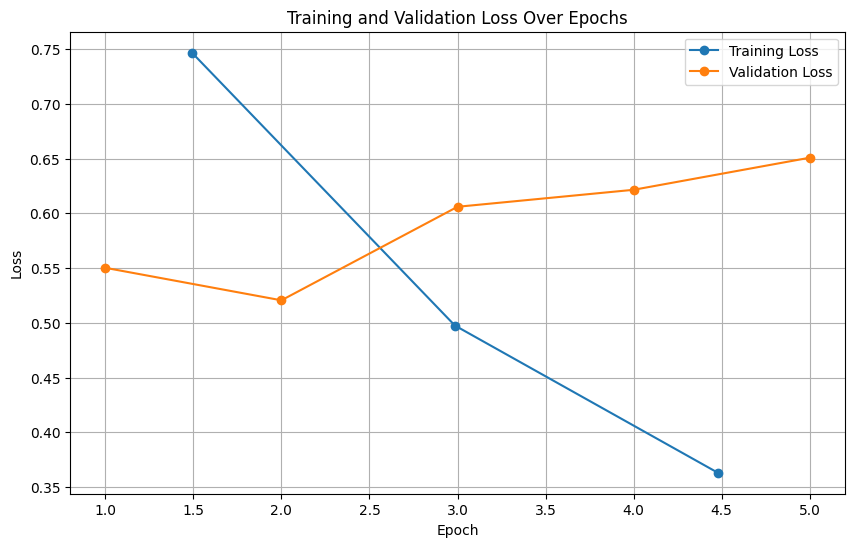

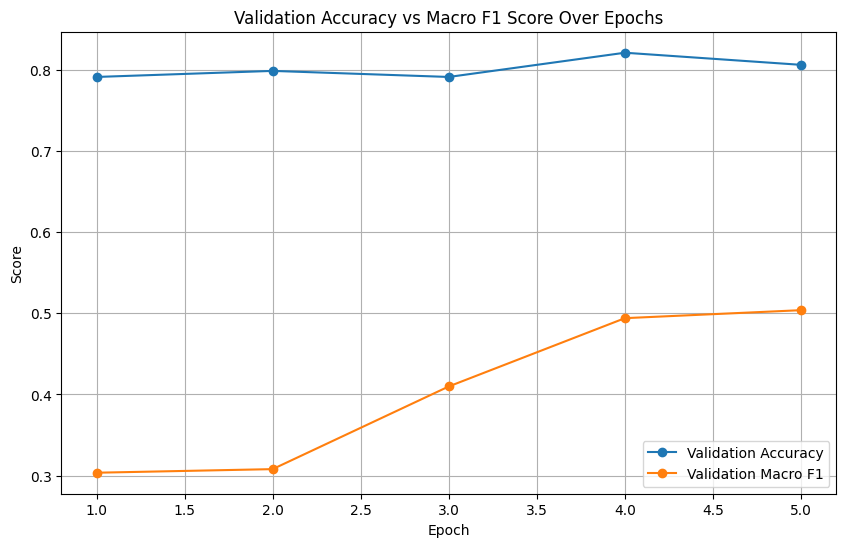

In [13]:
# Plot Learning Curves (Training and Validation Loss)
plt.figure(figsize=(10, 6))
train_epochs, train_loss_values = zip(*train_loss) if train_loss else ([], [])
val_epochs, val_loss_values = zip(*val_loss) if val_loss else ([], [])
plt.plot(train_epochs, train_loss_values, label='Training Loss', marker='o')
plt.plot(val_epochs, val_loss_values, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/GP(AI2025)/Data/learning_curve_loss_RoBERTa_Tutorial.png')
plt.show()

# Plot Accuracy and Macro F1 Score
plt.figure(figsize=(10, 6))
val_epochs, val_acc_values = zip(*val_accuracy) if val_accuracy else ([], [])
val_epochs, val_f1_values = zip(*val_macro_f1) if val_macro_f1 else ([], [])
plt.plot(val_epochs, val_acc_values, label='Validation Accuracy', marker='o')
plt.plot(val_epochs, val_f1_values, label='Validation Macro F1', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation Accuracy vs Macro F1 Score Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/GP(AI2025)/Data/accuracy_f1_curve_RoBERTa_Tutorial.png')
plt.show()


Test Set Evaluation:


Test Accuracy: 0.8370
Test Macro F1: 0.5514


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

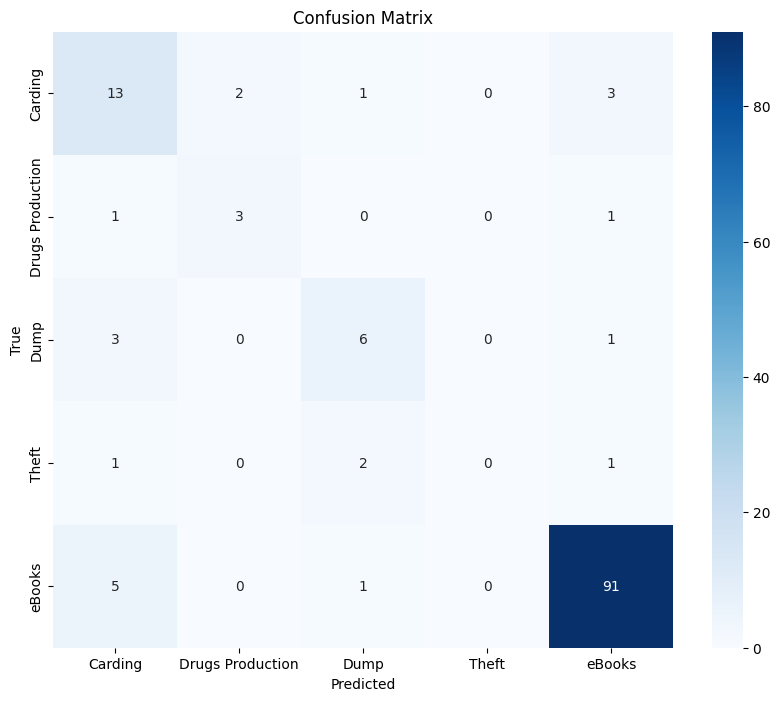


Classification Report:
                  precision    recall  f1-score   support

         Carding       0.57      0.68      0.62        19
Drugs Production       0.60      0.60      0.60         5
            Dump       0.60      0.60      0.60        10
           Theft       0.00      0.00      0.00         4
          eBooks       0.94      0.94      0.94        97

        accuracy                           0.84       135
       macro avg       0.54      0.56      0.55       135
    weighted avg       0.82      0.84      0.83       135



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
# Evaluate on test set
print("\nTest Set Evaluation:")
test_results = trainer.evaluate(tokenized_test)
print(f"Test Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"Test Macro F1: {test_results['eval_macro_f1']:.4f}")

# Generate predictions for confusion matrix
predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=1)

# Plot Confusion Matrix
cm = confusion_matrix(test_labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id2label[i] for i in sorted(id2label)],
            yticklabels=[id2label[i] for i in sorted(id2label)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/GP(AI2025)/Data/confusion_matrix_RoBERTa_Tutorial.png')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(
    test_labels,
    preds,
    target_names=[id2label[i] for i in sorted(id2label)]
))

In [ ]:
# save model to the same directory on drive
trainer.save_model("/content/drive/MyDrive/GP(AI2025)/Models/Tutorial Classification/roberta_tutorial_classifier")



---



# **Measuring Calibration**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, log_loss, brier_score_loss
from scipy import stats
import pandas as pd
from typing import Tuple, List, Dict, Any
import warnings
import torch
import torch.nn.functional as F
warnings.filterwarnings('ignore')
from sklearn.metrics import f1_score

In [ ]:
class CalibrationAnalyzer:
    """
    Calibration analysis for trained models - integrated into training notebooks.
    """

    def __init__(self, n_bins: int = 10):
        self.n_bins = n_bins
        self.results = {}

    def expected_calibration_error(self, y_true: np.ndarray, y_prob: np.ndarray) -> float:
        """Calculate Expected Calibration Error (ECE)."""
        if len(y_prob.shape) > 1 and y_prob.shape[1] > 1:
            confidences = np.max(y_prob, axis=1)
            predictions = np.argmax(y_prob, axis=1)
        else:
            y_prob = y_prob.flatten() if len(y_prob.shape) > 1 else y_prob
            confidences = np.maximum(y_prob, 1 - y_prob)
            predictions = (y_prob > 0.5).astype(int)

        bin_boundaries = np.linspace(0, 1, self.n_bins + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]

        ece = 0.0

        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
            prop_in_bin = in_bin.mean()

            if prop_in_bin > 0:
                accuracy_in_bin = (predictions[in_bin] == y_true[in_bin]).mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece

    def maximum_calibration_error(self, y_true: np.ndarray, y_prob: np.ndarray) -> float:
        """Calculate Maximum Calibration Error (MCE)."""
        if len(y_prob.shape) > 1 and y_prob.shape[1] > 1:
            confidences = np.max(y_prob, axis=1)
            predictions = np.argmax(y_prob, axis=1)
        else:
            y_prob = y_prob.flatten() if len(y_prob.shape) > 1 else y_prob
            confidences = np.maximum(y_prob, 1 - y_prob)
            predictions = (y_prob > 0.5).astype(int)

        bin_boundaries = np.linspace(0, 1, self.n_bins + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]

        mce = 0.0

        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = (confidences > bin_lower) & (confidences <= bin_upper)

            if in_bin.sum() > 0:
                accuracy_in_bin = (predictions[in_bin] == y_true[in_bin]).mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                bin_error = np.abs(avg_confidence_in_bin - accuracy_in_bin)
                mce = max(mce, bin_error)

        return mce

    def brier_score(self, y_true: np.ndarray, y_prob: np.ndarray) -> float:
        """Calculate Brier Score."""
        if len(y_prob.shape) > 1 and y_prob.shape[1] > 1:
            n_classes = y_prob.shape[1]
            y_true_onehot = np.zeros((len(y_true), n_classes))
            y_true_onehot[np.arange(len(y_true)), y_true] = 1
            return np.mean(np.sum((y_prob - y_true_onehot) ** 2, axis=1))
        else:
            y_prob = y_prob.flatten() if len(y_prob.shape) > 1 else y_prob
            return brier_score_loss(y_true, y_prob)

    def negative_log_likelihood(self, y_true: np.ndarray, y_prob: np.ndarray) -> float:
        """Calculate Negative Log-Likelihood."""
        try:
            if len(y_prob.shape) > 1 and y_prob.shape[1] > 1:
                return log_loss(y_true, y_prob, labels=list(range(y_prob.shape[1])))
            else:
                y_prob = y_prob.flatten() if len(y_prob.shape) > 1 else y_prob
                y_prob_binary = np.column_stack([1 - y_prob, y_prob])
                return log_loss(y_true, y_prob_binary)
        except:
            return float('inf')

    def reliability_diagram_data(self, y_true: np.ndarray, y_prob: np.ndarray):
        """Generate data for reliability diagram."""
        if len(y_prob.shape) > 1 and y_prob.shape[1] > 1:
            confidences = np.max(y_prob, axis=1)
            predictions = np.argmax(y_prob, axis=1)
        else:
            y_prob = y_prob.flatten() if len(y_prob.shape) > 1 else y_prob
            confidences = np.maximum(y_prob, 1 - y_prob)
            predictions = (y_prob > 0.5).astype(int)

        bin_boundaries = np.linspace(0, 1, self.n_bins + 1)
        bin_centers = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2

        bin_accuracies = []
        bin_confidences = []
        bin_counts = []

        for i in range(self.n_bins):
            bin_lower = bin_boundaries[i]
            bin_upper = bin_boundaries[i + 1]
            in_bin = (confidences > bin_lower) & (confidences <= bin_upper)

            if in_bin.sum() > 0:
                bin_accuracy = (predictions[in_bin] == y_true[in_bin]).mean()
                bin_confidence = confidences[in_bin].mean()
                bin_count = in_bin.sum()
            else:
                bin_accuracy = 0.0
                bin_confidence = 0.0
                bin_count = 0

            bin_accuracies.append(bin_accuracy)
            bin_confidences.append(bin_confidence)
            bin_counts.append(bin_count)

        return {
            'bin_centers': bin_centers,
            'accuracies': np.array(bin_accuracies),
            'confidences': np.array(bin_confidences),
            'counts': np.array(bin_counts)
        }

    def plot_reliability_diagram(self, y_true: np.ndarray, y_prob: np.ndarray,
                                 model_name: str = "Model", figsize=(8, 6)):
        """Plot reliability diagram for a single model."""
        rel_data = self.reliability_diagram_data(y_true, y_prob)

        plt.figure(figsize=figsize)
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.7, label='Perfect Calibration')

        mask = rel_data['counts'] > 0
        plt.bar(rel_data['bin_centers'][mask],
                rel_data['accuracies'][mask],
                width=0.08, alpha=0.7, color='skyblue',
                label=f'{model_name} Accuracy')

        plt.plot(rel_data['bin_centers'][mask],
                 rel_data['confidences'][mask],
                 'ro-', linewidth=2, markersize=6,
                 label=f'{model_name} Confidence')

        for i, (center, count, accuracy) in enumerate(zip(rel_data['bin_centers'],
                                                          rel_data['counts'],
                                                          rel_data['accuracies'])):
            if count > 0:
                plt.text(center, accuracy + 0.02, str(count),
                         ha='center', va='bottom', fontsize=9, fontweight='bold')

        ece = self.expected_calibration_error(y_true, y_prob)

        plt.xlabel('Confidence', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.title(f'{model_name} Reliability Diagram\nECE: {ece:.4f}', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()

        return rel_data

    def comprehensive_evaluation(self, y_true: np.ndarray, y_prob: np.ndarray,
                                 model_name: str = "Model") -> Dict[str, float]:
        """Complete calibration evaluation with all metrics."""
        if len(y_prob.shape) > 1 and y_prob.shape[1] > 1:
            predictions = np.argmax(y_prob, axis=1)
        else:
            predictions = (y_prob > 0.5).astype(int)

        metrics = {
            'ECE': self.expected_calibration_error(y_true, y_prob),
            'MCE': self.maximum_calibration_error(y_true, y_prob),
            'Brier_Score': self.brier_score(y_true, y_prob),
            'NLL': self.negative_log_likelihood(y_true, y_prob),
            'Accuracy': accuracy_score(y_true, predictions),
            'F1_Score': f1_score(y_true, predictions, average='weighted')
        }

        print(f"\n🎯 CALIBRATION ANALYSIS FOR {model_name.upper()}")
        print("=" * 50)
        print(f"📊 Expected Calibration Error (ECE): {metrics['ECE']:.4f}")
        print(f"📊 Maximum Calibration Error (MCE): {metrics['MCE']:.4f}")
        print(f"📊 Brier Score:                      {metrics['Brier_Score']:.4f}")
        print(f"📊 Negative Log-Likelihood (NLL):   {metrics['NLL']:.4f}")
        print(f"📊 Accuracy:                        {metrics['Accuracy']:.4f}")
        print(f"📊 F1 Score (Weighted):             {metrics['F1_Score']:.4f}")

        print("\n💡 INTERPRETATION:")
        if metrics['ECE'] < 0.05:
            print("✅ Excellent calibration (ECE < 0.05)")
        elif metrics['ECE'] < 0.10:
            print("🟡 Good calibration (ECE < 0.10)")
        elif metrics['ECE'] < 0.15:
            print("🟠 Fair calibration (ECE < 0.15)")
        else:
            print("🔴 Poor calibration (ECE ≥ 0.15)")

        self.results[model_name] = metrics
        return metrics

In [ ]:
def analyze_model_calibration(trainer, tokenized_test, test_labels, model_name="RoBERTa"):
    """
    Analyze calibration for a trained model.
    Call this function after training your model.

    Args:
        trainer: The Hugging Face Trainer object
        tokenized_test: Tokenized test dataset
        test_labels: True test labels
        model_name: Name of the model (e.g., "DarkBERT", "BERT", "RoBERTa")

    Returns:
        Calibration metrics dictionary
    """

    print(f"\n🚀 STARTING CALIBRATION ANALYSIS FOR {model_name}")
    print("=" * 60)

    # Get predictions and probabilities
    print("📊 Getting model predictions...")
    predictions = trainer.predict(tokenized_test)

    # Extract probabilities (softmax of logits)
    logits = predictions.predictions
    probabilities = F.softmax(torch.from_numpy(logits), dim=-1).numpy()

    print(f"✅ Predictions obtained. Shape: {probabilities.shape}")

    # Initialize calibration analyzer
    calibrator = CalibrationAnalyzer(n_bins=10)

    # Comprehensive evaluation
    metrics = calibrator.comprehensive_evaluation(
        y_true=np.array(test_labels),
        y_prob=probabilities,
        model_name=model_name
    )

    # Plot reliability diagram
    print(f"\n📈 Generating reliability diagram...")
    rel_data = calibrator.plot_reliability_diagram(
        y_true=np.array(test_labels),
        y_prob=probabilities,
        model_name=model_name,
        figsize=(10, 8)
    )

    # Additional analysis
    print(f"\n📋 DETAILED ANALYSIS:")
    print(f"   • Total test samples: {len(test_labels)}")
    print(f"   • Number of classes: {probabilities.shape[1]}")
    print(f"   • Average confidence: {np.max(probabilities, axis=1).mean():.4f}")
    print(f"   • Confidence std: {np.max(probabilities, axis=1).std():.4f}")

    # Confidence distribution analysis
    confidences = np.max(probabilities, axis=1)
    print(f"   • Low confidence samples (<0.5): {(confidences < 0.5).sum()}")
    print(f"   • Medium confidence samples (0.5-0.8): {((confidences >= 0.5) & (confidences < 0.8)).sum()}")
    print(f"   • High confidence samples (≥0.8): {(confidences >= 0.8).sum()}")

    return metrics, probabilities, calibrator

In [ ]:
def save_calibration_results(metrics, model_name, save_path):
    """
    Save calibration results to file for later comparison.

    Args:
        metrics: Dictionary of calibration metrics
        model_name: Name of the model
        save_path: Path to save the results
    """

    results_df = pd.DataFrame([metrics])
    results_df.index = [model_name]

    # Save to CSV
    csv_path = f"{save_path}/{model_name.lower()}_calibration_results.csv"
    results_df.to_csv(csv_path)

    print(f"💾 Calibration results saved to: {csv_path}")

    return csv_path


🎯 STARTING CALIBRATION ANALYSIS

🚀 STARTING CALIBRATION ANALYSIS FOR RoBERTa
📊 Getting model predictions...


✅ Predictions obtained. Shape: (135, 5)

🎯 CALIBRATION ANALYSIS FOR ROBERTA
📊 Expected Calibration Error (ECE): 0.0659
📊 Maximum Calibration Error (MCE): 0.7203
📊 Brier Score:                      0.2248
📊 Negative Log-Likelihood (NLL):   0.4748
📊 Accuracy:                        0.8370
📊 F1 Score (Weighted):             0.8126

💡 INTERPRETATION:
🟡 Good calibration (ECE < 0.10)

📈 Generating reliability diagram...


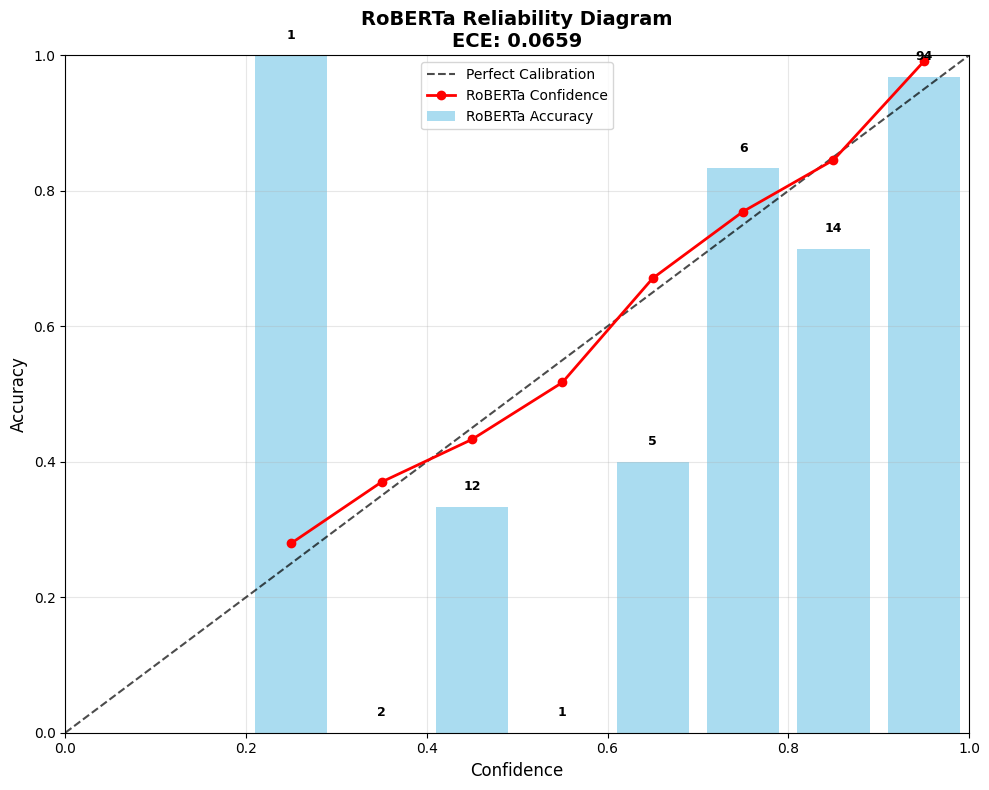


📋 DETAILED ANALYSIS:
   • Total test samples: 135
   • Number of classes: 5
   • Average confidence: 0.8866
   • Confidence std: 0.1905
   • Low confidence samples (<0.5): 15
   • Medium confidence samples (0.5-0.8): 12
   • High confidence samples (≥0.8): 108
💾 Calibration results saved to: /content/drive/MyDrive/GP(AI2025)/Models/Tutorial Classification/roberta_tutorial_classifier/roberta_calibration_results.csv


In [ ]:
# =============================================================================
# INTEGRATION CODE - ADD THIS TO YOUR DARKBERT NOTEBOOK
# =============================================================================

"""
ADD THIS CODE TO YOUR DARKBERT NOTEBOOK AFTER THE TRAINING IS COMPLETE:
(Right after the line: trainer.save_model("/content/drive/MyDrive/..."))
"""

# After your existing code, add:
print("\n" + "="*80)
print("🎯 STARTING CALIBRATION ANALYSIS")
print("="*80)

# Analyze calibration for DarkBERT
darkbert_metrics, darkbert_probs, darkbert_calibrator = analyze_model_calibration(
    trainer=trainer,
    tokenized_test=tokenized_test,
    test_labels=test_labels,
    model_name="RoBERTa"
)

# Save results for later comparison
save_calibration_results(
    metrics=darkbert_metrics,
    model_name="RoBERTa",
    save_path="/content/drive/MyDrive/GP(AI2025)/Models/Tutorial Classification/roberta_tutorial_classifier"
)

# Save probabilities for statistical comparison later
np.save("/content/drive/MyDrive/GP(AI2025)/Models/Tutorial Classification/roberta_tutorial_classifier/roberta_test_probabilities.npy",
        darkbert_probs)
np.save("/content/drive/MyDrive/GP(AI2025)/Models/Tutorial Classification/roberta_tutorial_classifier/test_labels.npy",
        test_labels)